In [1]:
using Plots
using TensorCrossInterpolation, LinearAlgebra
using QuanticsTCI
using QuanticsGrids
using ITensorMPS
using ITensors
using TCIITensorConversion

In [2]:
function u_1(x,y)
    return cos(x) * sin(y) # d/dx u_1 = -sin(x) * sin(y) || d/dy u_1 = cos(x) * cos(y)
end
function u_2(x,y)
    return -sin(x) * sin(y)
end

u_2 (generic function with 1 method)

In [3]:
R = 10
D = 2
xmin = 0.0
xmax = 2 * π
ymin = 0.0
ymax = 2 * π
dx = float(abs(xmin - xmax) / 2^R)
qgrid = DiscretizedGrid{D}(R, (xmin, ymin), (xmax, ymax); includeendpoint = true)
maxbonddim=30

30

In [4]:
u1, ranks2, errors2 = quanticscrossinterpolate(Float64, u_1, qgrid; tolerance=1e-8)
u2, ranks2, errors2 = quanticscrossinterpolate(Float64, u_2, qgrid; tolerance=1e-8)

(QuanticsTCI.QuanticsTensorCI2{Float64}(TensorCrossInterpolation.TensorCI2{Float64} with rank 4, DiscretizedGrid{2}(10, (0.0, 0.0), (6.283185307179586, 6.283185307179586), 2, :fused, true), TensorCrossInterpolation.CachedFunction{Float64, BitIntegers.UInt256} with 2274 entries), [4, 4, 4], [4.571007136252531e-16, 4.571007136252531e-16, 4.571007136252531e-16])

In [5]:
u1_mps = ITensorMPS.MPS(TensorTrain(u1.tci))
s = siteinds(u1_mps)
u2_mps = ITensorMPS.MPS(TensorTrain(u2.tci), sites=s)
s

10-element Vector{Index{Int64}}:
 (dim=4|id=315|"n=1")
 (dim=4|id=262|"n=2")
 (dim=4|id=122|"n=3")
 (dim=4|id=599|"n=4")
 (dim=4|id=481|"n=5")
 (dim=4|id=966|"n=6")
 (dim=4|id=401|"n=7")
 (dim=4|id=926|"n=8")
 (dim=4|id=887|"n=9")
 (dim=4|id=720|"n=10")

In [6]:
function custom_mpo(::Type{ElT}, sites::Vector{<:Index}, linkdim::Int) where {ElT<:Number}
    N = length(sites)
    v = Vector{ITensor}(undef, N)
    if N == 0
      return MPO()
    elseif N == 1
      v[1] = ITensor(ElT, dag(sites[1]), sites[1]')
      return MPO(v)
    end
    space_ii = linkdim
    l = [Index(space_ii, "Link,l=$ii") for ii in 1:(N - 1)]
    for ii in eachindex(sites)
      s = sites[ii]
      if ii == 1
        v[ii] = ITensor(ElT, dag(s), s', l[ii])
      elseif ii == N
        v[ii] = ITensor(ElT, dag(l[ii - 1]), dag(s), s')
      else
        v[ii] = ITensor(ElT, dag(l[ii - 1]), dag(s), s', l[ii])
      end
    end
  return MPO(v)
end

custom_mpo (generic function with 1 method)

In [7]:
dfdx = custom_mpo(ComplexF64, s, 3)
dfdy = custom_mpo(ComplexF64, s, 3)
d2fdx2 = custom_mpo(ComplexF64, s, 3)
d2fdy2 = custom_mpo(ComplexF64, s, 3)

MPO
[1] ((dim=4|id=315|"n=1"), (dim=4|id=315|"n=1")', (dim=3|id=184|"Link,l=1"))
[2] ((dim=3|id=184|"Link,l=1"), (dim=4|id=262|"n=2"), (dim=4|id=262|"n=2")', (dim=3|id=853|"Link,l=2"))
[3] ((dim=3|id=853|"Link,l=2"), (dim=4|id=122|"n=3"), (dim=4|id=122|"n=3")', (dim=3|id=107|"Link,l=3"))
[4] ((dim=3|id=107|"Link,l=3"), (dim=4|id=599|"n=4"), (dim=4|id=599|"n=4")', (dim=3|id=399|"Link,l=4"))
[5] ((dim=3|id=399|"Link,l=4"), (dim=4|id=481|"n=5"), (dim=4|id=481|"n=5")', (dim=3|id=431|"Link,l=5"))
[6] ((dim=3|id=431|"Link,l=5"), (dim=4|id=966|"n=6"), (dim=4|id=966|"n=6")', (dim=3|id=364|"Link,l=6"))
[7] ((dim=3|id=364|"Link,l=6"), (dim=4|id=401|"n=7"), (dim=4|id=401|"n=7")', (dim=3|id=64|"Link,l=7"))
[8] ((dim=3|id=64|"Link,l=7"), (dim=4|id=926|"n=8"), (dim=4|id=926|"n=8")', (dim=3|id=996|"Link,l=8"))
[9] ((dim=3|id=996|"Link,l=8"), (dim=4|id=887|"n=9"), (dim=4|id=887|"n=9")', (dim=3|id=499|"Link,l=9"))
[10] ((dim=3|id=499|"Link,l=9"), (dim=4|id=720|"n=10"), (dim=4|id=720|"n=10")')


In [ ]:
function Diff_fill(mpo, J, Jp, alpha_, beta, gamma)
    Id = zeros(eltype(J), size(J))
    Id[:,:] = I(size(J)[1])

    for (i,v) in enumerate(mpo)
        mat = fill(0.0, dim.(inds(v)))
        if i == 1
            mat[:,:,1] = Id
            mat[:,:,2] = Jp
            mat[:,:,3] = J
        elseif i == R
            mat[1,:,:] = (alpha_*Id + beta * J + gamma * Jp)
            mat[2,:,:] = gamma * J
            mat[3,:,:] = beta * Jp
        else
            mat[1,:,:,1] = Id
            mat[1,:,:,2] = Jp
            mat[1,:,:,3] = J 
            mat[2,:,:,2] = J 
            mat[3,:,:,3] = Jp
        end
        mpo[i] = ITensor(mat, inds(v))
    end
    
end

function Diff_1_2_x(h, sites)
    
end

Id = fill(0.0, (2^D,2^D))
Id[:,:] = I(2^D)

alpha_ = 0
beta = 1 / (2*dx)
gamma = -1 / (2*dx)

J = fill(0.0, (2^D,2^D))
Jp = fill(0.0, (2^D,2^D))
J[2, 1] = 1
J[4, 3] = 1
Jp[1,2] = 1
Jp[3,4] = 1

# d/dx


for (i,v) in enumerate(dfdx)
    mat = fill(0.0, dim.(inds(v)))
    
    if i == 1
        mat[:,:,1] = Id
        mat[:,:,2] = Jp
        mat[:,:,3] = J
        
    elseif i == R
        mat[1,:,:] = (alpha_*Id + beta * J + gamma * Jp)
        mat[2,:,:] = gamma * J
        mat[3,:,:] = beta * Jp
    else
        mat[1,:,:,1] = Id
        mat[1,:,:,2] = Jp
        mat[1,:,:,3] = J 
        mat[2,:,:,2] = J 
        mat[3,:,:,3] = Jp
    end
        
    dfdx[i] = ITensor(mat, inds(v))

end


# d/dy

J = fill(0.0, (2^D,2^D))
Jp = fill(0.0, (2^D,2^D))
J[3, 1] = 1
J[4, 2] = 1
Jp[1,3] = 1
Jp[2,4] = 1

for (i,v) in enumerate(dfdy)
    mat = fill(0.0, dim.(inds(v)))
    
    if i == 1
        mat[:,:,1] = Id
        mat[:,:,2] = Jp
        mat[:,:,3] = J
        
    elseif i == R
        mat[1,:,:] = (alpha_*Id + beta * J + gamma * Jp)
        mat[2,:,:] = gamma * J
        mat[3,:,:] = beta * Jp
    else
        mat[1,:,:,1] = Id
        mat[1,:,:,2] = Jp
        mat[1,:,:,3] = J 
        mat[2,:,:,2] = J 
        mat[3,:,:,3] = Jp
    end
        
    dfdy[i] = ITensor(mat, inds(v))

end

alpha_ = -2 / dx^2
beta = 1 / dx^2
gamma = 1 / dx^2

J = fill(0.0, (2^D,2^D))
Jp = fill(0.0, (2^D,2^D))
J[2, 1] = 1
J[4, 3] = 1
Jp[1,2] = 1
Jp[3,4] = 1

# d/dx


for (i,v) in enumerate(d2fdx2)
    mat = fill(0.0, dim.(inds(v)))
    
    if i == 1
        mat[:,:,1] = Id
        mat[:,:,2] = Jp
        mat[:,:,3] = J
        
    elseif i == R
        mat[1,:,:] = (alpha_*Id + beta * J + gamma * Jp)
        mat[2,:,:] = gamma * J
        mat[3,:,:] = beta * Jp
    else
        mat[1,:,:,1] = Id
        mat[1,:,:,2] = Jp
        mat[1,:,:,3] = J 
        mat[2,:,:,2] = J 
        mat[3,:,:,3] = Jp
    end
        
    d2fdx2[i] = ITensor(mat, inds(v))

end


# d/dy

J = fill(0.0, (2^D,2^D))
Jp = fill(0.0, (2^D,2^D))
J[3, 1] = 1
J[4, 2] = 1
Jp[1,3] = 1
Jp[2,4] = 1

for (i,v) in enumerate(d2fdy2)
    mat = fill(0.0, dim.(inds(v)))
    
    if i == 1
        mat[:,:,1] = Id
        mat[:,:,2] = Jp
        mat[:,:,3] = J
        
    elseif i == R
        mat[1,:,:] = (alpha_*Id + beta * J + gamma * Jp)
        mat[2,:,:] = gamma * J
        mat[3,:,:] = beta * Jp
    else
        mat[1,:,:,1] = Id
        mat[1,:,:,2] = Jp
        mat[1,:,:,3] = J 
        mat[2,:,:,2] = J 
        mat[3,:,:,3] = Jp
    end
        
    d2fdy2[i] = ITensor(mat, inds(v))

end

In [9]:
u1_mps_dx = apply(dfdx, u1_mps, maxdim=maxbonddim)
u1_mps_dy = apply(dfdy, u1_mps, maxdim=maxbonddim)
u1_dx_tci = TensorCrossInterpolation.TensorTrain(u1_mps_dx)
u1_dy_tci = TensorCrossInterpolation.TensorTrain(u1_mps_dx)

(::TensorTrain{ComplexF64, 3}) (generic function with 1 method)

In [10]:
N = 8 # -> 2^8=256 points
n = R - N
xvec = 1:2^n:2^R
yvec = 1:2^n:2^R
xvals = collect(range(xmin, xmax, 2^N))
yvals = collect(range(ymin, ymax, 2^N))

u1vals = fill(0.0, (2^N, 2^N))
u1dxvals = fill(0.0, (2^N, 2^N))
u1dyvals = fill(0.0, (2^N, 2^N))

for x in 1:2^N
    for y in 1:2^N
        u1vals[y,x] = u1.tci(grididx_to_quantics(qgrid, (xvec[x], yvec[y])))
        u1dxvals[y,x] = u1_dx_tci(grididx_to_quantics(qgrid, (xvec[x], yvec[y])))
        u1dyvals[y,x] = u1_dy_tci(grididx_to_quantics(qgrid, (xvec[x], yvec[y])))
    end
end

print("done!")

done!

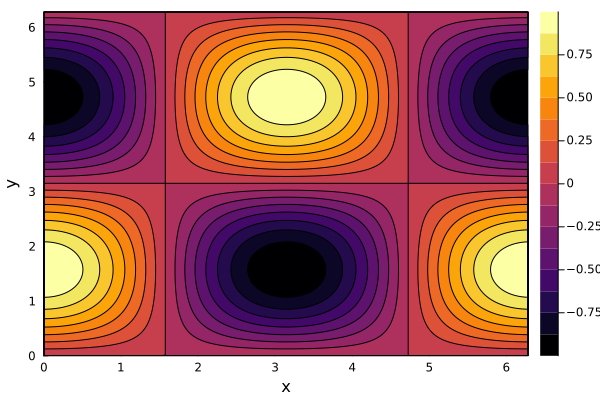

In [11]:
contour(xvals, yvals, u1vals, fill=true)
xlabel!("x")
ylabel!("y")

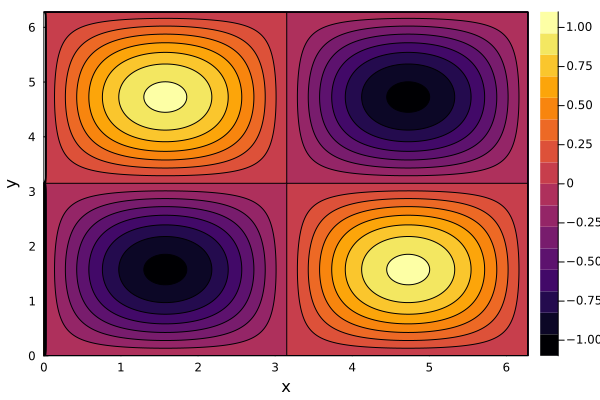

In [12]:
contour(xvals, yvals, u1dxvals, fill=true, clim=(-1.1,1.1))
xlabel!("x")
ylabel!("y")

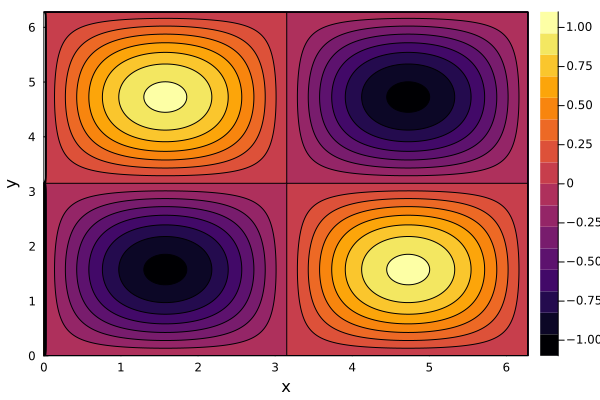

In [13]:
contour(xvals, yvals, u1dyvals, fill=true, clim=(-1.1,1.1))
xlabel!("x")
ylabel!("y")